In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import random
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from scipy import sparse

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve

import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import link_prediction

PROJECT_DIR = os.path.abspath('/content/drive/My Drive/Colab Notebooks/COMP596/project/')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
ML_1M_DIR = os.path.join(DATA_DIR, 'ml-1m')

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/COMP596/project/utils')
from utils import create_movielens_graph, load_movies, load_movies_formatted, apply_movie_attributes

In [0]:
graph = create_movielens_graph(ML_1M_DIR, max_edges=None)
movies = load_movies(ML_1M_DIR)
apply_movie_attributes(graph, movies);
del movies

In [0]:
def drop_edges(graph, percentage=0.2, seed=42, get_data=True):
    """Drop a percentage of edges in the graph (not inplace)
        get_data=True will return the sampled edges' data but won't affect sampling or removal
    """
    num_edges = int(len(graph.edges()) * percentage)
    
    random.seed(seed)
    sampled_edges = random.sample(list(graph.edges(data=get_data)), num_edges)
    
    graph_copy = graph.copy()
#     for edge in tqdm_notebook(sampled_edges, desc='Dropping sampled edges'):
    for edge in sampled_edges:
        if get_data:
            u, v, _ = edge
        else:
            u,v = edge
            
        graph_copy.remove_edge(u, v)
    return graph_copy, sampled_edges

In [0]:
# def generate_random_candidates(graph, num_candidates=50):
#     random.seed(42)
#     user_nodes, movie_nodes = bipartite.sets(graph)
#     walks = {user: {} for user in user_nodes}
#     adj_dict = nx.to_dict_of_dicts(graph)
    
#     for user, _ in walks.items():
#         random_movies = random.sample(movie_nodes, num_candidates)
#         neighbors = graph.neighbors(user)
#         attrs = {}
#         for movie in random_movies:
#             attrs[movie] = adj_dict[user][movie] if movie in neighbors else 0
#         walks[user] = attrs
    
#     return walks


def generate_walks(graph_valid, dropped_edges, non_edges):
    """Used to create walks for training and validation with ground truth ratings for link prediction validation"""
    USER = 0
    users = np.unique([e[USER] for e in dropped_edges]).tolist()
    users.extend(np.unique([e[USER] for e in non_edges]))

    walks_valid = {user: {} for user in users}
    walks_train = {user: {} for user in users}
    degrees = graph_valid.degree
    
    for edge in dropped_edges:
        user, movie, data = edge
        
#         user_degree = degrees[user]
#         prob = int(data['rating']) / user_degree
        
        walks_valid[user][movie] = 1
        walks_train[user][movie] = 0
        
    for edge in non_edges:
        user, movie = edge
        
        walks_valid[user][movie] = 0
        walks_train[user][movie] = 0
        
    return walks_train, walks_valid


def random_baseline(walks, seed=42):
    
    random.seed(42)
    for user, movies in walks.items():
        
        for movie in movies:
            
            walks[user][movie] = random.random()
    
    return walks

def run_random_walks(graph, walks):
    
    # Used for calculating random walk probabilities
    adj_matrix = nx.adjacency_matrix(graph, weight='rating')
    inverse_degree_matrix = sparse.diags([[1.0 / adj_matrix.getrow(i).sum()
                                           for i in range(adj_matrix.shape[0])]], [0])
    transition_matrix = inverse_degree_matrix.dot(adj_matrix)
    
    # Adjacency matrix uses the following order of nodes, so I need this order to correctly
    # index for edges in the adjacency matrix
    ordered_nodes = list(graph.nodes)
    
    users = list(walks.keys())
    for user in tqdm_notebook(users, desc='Running random walks'):
        
        user_index = ordered_nodes.index(user)
        probs = run_random_walk(transition_matrix, int(user_index)).todense()
        movies = walks[user]
        for movie in movies:
            movie_index = ordered_nodes.index(movie)
            walks[user][movie] = probs[0, movie_index]
    
    return walks
         
    
def run_random_walk(transition_matrix, node, iterations=10, walk_p=0.2):
    """Computes walk probabilities for a given node and its neighbors"""
    probs = np.zeros(transition_matrix.shape[0])
    probs[node] = 1.0
    probs = sparse.csr_matrix(probs)

    for i in range(iterations):
        probs = np.dot(probs, transition_matrix)
        probs *= (1 - walk_p)
        probs[0, node] += walk_p

    return probs


def sample(dist, seed=42, num_samples=1000):
    random.seed(seed)
    return random.sample(dist, num_samples)

In [0]:
graph_cp, dropped_edges = drop_edges(graph)

In [0]:
users, movies = bipartite.sets(graph)
non_edges = [edge for edge in list(nx.non_edges(graph)) if edge[0] in users and edge[1] in movies]
sampled_non_edges = sample(non_edges, num_samples=len(dropped_edges))

In [0]:
rand_base_walks = random_baseline(walks_train)

In [0]:
walks_train, walks_valid = generate_walks(graph, dropped_edges, sampled_non_edges)

In [0]:
walks_estimates = run_random_walks(graph_cp, walks_train);

In [0]:
def run_evaluation(predictions, truth, precision_at=20):
    curve_args = []
    total_precision = 0
    all_ys, all_ps = [], []
    for node, candidates in predictions.items():
        ys, ps = zip(*[(truth[node][candidate], predictions[node][candidate]) for candidate in predictions[node]])
        all_ys += ys
        all_ps += ps

        n = min(precision_at, len(ys))
        top_ys = sorted(zip(ys, ps), key=itemgetter(1), reverse=True)[0][:n]
        total_precision += sum(top_ys) / float(n)
    
#     pdb.set_trace()
    roc_auc = roc_auc_score(all_ys, all_ps)
    fpr, tpr, t = roc_curve(all_ys, all_ps)
    
#     COLORS = ['r', 'b', 'g', 'm', 'y', 'c', 'k', '#FF9900', '#006600', '#663300']
#     curve_args.append((fpr, tpr, COLORS[i % len(COLORS)]))
    curve_args.append((fpr, tpr, 'r'))

    plt.figure(figsize=(5, 5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.title('ROC Curve')
    for (fpr, tpr, color) in curve_args:
        plt.plot(fpr, tpr, label='Random Walk', color=color)
    plt.legend(loc="best")
    plt.show()
    
    precision = total_precision / len(truth)
    print (f"Precision @{precision_at} = {precision:.4f}")
    print (f"ROC Auc = {roc_auc:.4f}")

    return roc_auc

Run [0]


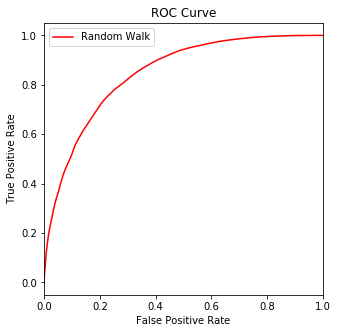

Precision @5 = 0.1825
ROC Auc = 0.8452
Run [1]


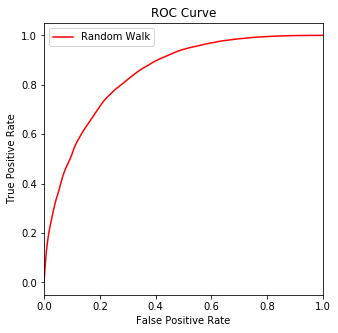

Precision @5 = 0.1825
ROC Auc = 0.8446
Run [2]


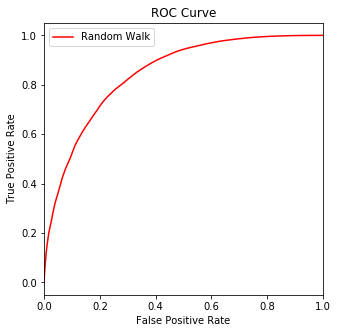

Precision @5 = 0.1827
ROC Auc = 0.8451
Run [3]


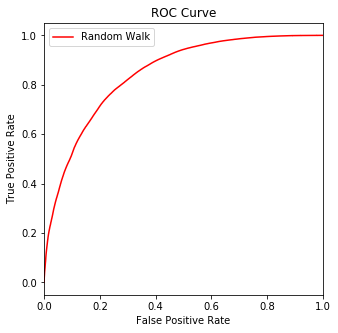

Precision @5 = 0.1837
ROC Auc = 0.8447
Run [4]


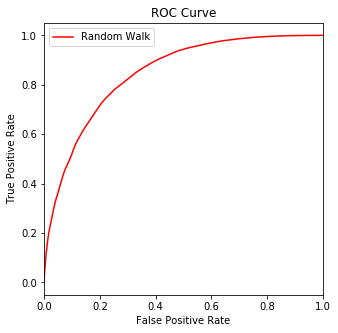

Precision @5 = 0.1835
ROC Auc = 0.8456
Run [5]


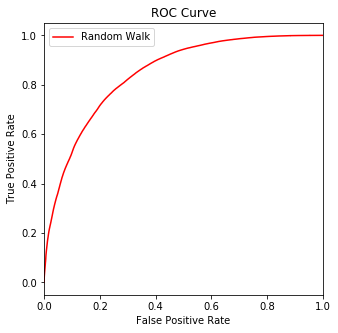

Precision @5 = 0.1835
ROC Auc = 0.8457
Run [6]


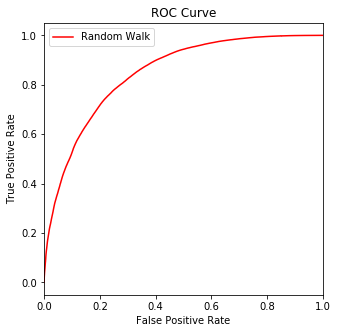

Precision @5 = 0.1835
ROC Auc = 0.8462
Run [7]


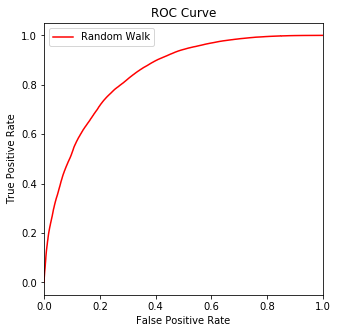

Precision @5 = 0.1832
ROC Auc = 0.8456
Run [8]


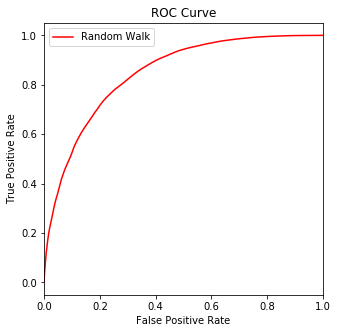

Precision @5 = 0.1839
ROC Auc = 0.8458
Run [9]


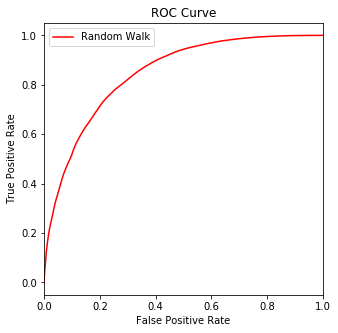

Precision @5 = 0.1826
ROC Auc = 0.8450
Average ROC AUC: 0.8453414059705796


In [0]:
# if you want to suppress warnings 
import warnings
warnings.filterwarnings("ignore")

history = []
for i in range(10):
    print(f'Run [{i}]')
    graph = create_movielens_graph(ML_1M_DIR, max_edges=None)
    graph_cp, dropped_edges = drop_edges(graph)
    users, movies = bipartite.sets(graph)
    non_edges = [edge for edge in list(nx.non_edges(graph)) if edge[0] in users and edge[1] in movies]
    sampled_non_edges = sample(non_edges, num_samples=len(dropped_edges), seed=i)
    walks_train, walks_valid = generate_walks(graph, dropped_edges, sampled_non_edges)
    walks_estimates = run_random_walks(graph_cp, walks_train);

    
    score = run_evaluation(walks_estimates, walks_valid, precision_at=5)
    history.append(score)
print(f'Average ROC AUC: {np.average(history)}')

In [0]:
run_evaluation(walks_estimates, walks_valid, precision_at=5)

NameError: ignored

In [0]:
nx.pagerank_numpy(graph)

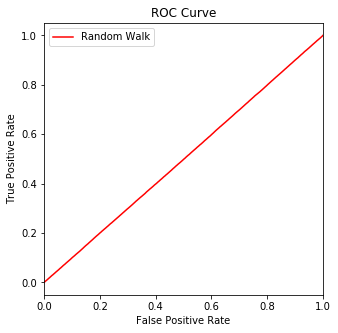

Precision @20 = 0.0767
ROC Auc = 0.4990


In [0]:
run_evaluation(rand_base_walks, walks_valid)

In [0]:
walks_valid['u1']

{'m1022': 1, 'm919': 1, 'm1287': 1, 'm2791': 1, 'm150': 1}

In [0]:
def print_statistics(graph):
    print(f'Number of Nodes:\t {graph.number_of_nodes()}')
    print(f'Number of Edges:\t {graph.number_of_edges()}')
    print(f'Average Degree:\t {np.average([d[1] for d in graph.degree])}')
    print(f'Is Connected?:\t {nx.is_connected(graph)}')
    
    
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    plt.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.')
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title('Degree Distribution')
    plt.show()

Number of Nodes:	 9746
Number of Edges:	 1000209
Average Degree:	 205.25528421916684
Is Connected?:	 True


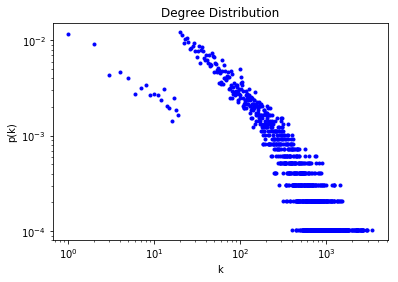

In [0]:
print_statistics(graph)
plot_degree_dist(graph)

In [0]:
graph_int = nx.Graph()

In [0]:
graph_int = nx.Graph()
# users_int = [int(u[1:]) for u in users]
# movies_int = [int(m[1:]) + len(users_int) for m in movies]

users_len = len(users)
for edge in graph.edges():
    u, v = edge
    u = int(u[1:])
    v = int(v[1:]) + users_len
    
    graph_int.add_edge(u, v)

In [0]:
nx.write_edgelist(graph_int, 'ml_1m.edgelist', delimiter=' ', data=False)